In [17]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import time
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from sklearn.utils import shuffle
import numpy.random as rng
from google.colab.patches import cv2_imshow

In [ ]:
!unzip images_background.zip

In [ ]:
!unzip images_evaluation.zip

In [47]:
train_folder = "./images_background/images_background/"
test_folder = './images_evaluation/images_evaluation/'
save_path = './data/'

In [48]:
def load(path,n = 0):
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = cv2.imread(image_path)
                # cv2_imshow(image)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [49]:
X,y,c = load(train_folder) 

loading alphabet: Hebrew
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Balinese
loading alphabet: Latin
loading alphabet: Tagalog
loading alphabet: N_Ko
loading alphabet: Japanese_(hiragana)
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Futurama
loading alphabet: Greek
loading alphabet: Early_Aramaic
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Grantha
loading alphabet: Japanese_(katakana)
loading alphabet: Armenian
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Arcadian
loading alphabet: Cyrillic
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Korean
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Braille
loading alphabet: Tifinagh
loading alphabet: Burmese_(Myanmar)
loading alphabet: Sanskrit
loading alphabet: Gujarati
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Bengali


In [50]:
X.shape

(964, 20, 105, 105)

In [51]:
with open(os.path.join(save_path, "train.pickle"), "wb") as f:
    pickle.dump((X,c), f)

In [52]:
X_test, y_test, c_test = load(test_folder)

loading alphabet: Syriac_(Serto)
loading alphabet: Glagolitic
loading alphabet: Tibetan
loading alphabet: Keble
loading alphabet: Ge_ez
loading alphabet: Kannada
loading alphabet: Atemayar_Qelisayer
loading alphabet: Mongolian
loading alphabet: Sylheti
loading alphabet: Angelic
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Oriya
loading alphabet: Gurmukhi
loading alphabet: ULOG
loading alphabet: Atlantean
loading alphabet: Malayalam
loading alphabet: Manipuri
loading alphabet: Tengwar
loading alphabet: Aurek-Besh
loading alphabet: Avesta


In [53]:
with open(os.path.join(save_path, "test.pickle"), "wb") as f:
    pickle.dump((X_test,c_test), f)

In [54]:
def initialize_weights(shape, dtype = None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [55]:
def initialize_bias(shape, dtype = None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [56]:
def get_siamese_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation = 'relu', input_shape = input_shape,
                     kernel_initializer = initialize_weights, kernel_regularizer = l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation = 'relu', kernel_initializer = initialize_weights,
                     bias_initializer = initialize_bias, kernel_regularizer = l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation = 'relu', kernel_initializer = initialize_weights,
                     bias_initializer = initialize_bias, kernel_regularizer = l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation = 'relu', 
                     kernel_initializer = initialize_weights, bias_initializer = initialize_bias, kernel_regularizer = l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation = 'sigmoid', 
                    kernel_initializer = initialize_weights, bias_initializer = initialize_bias, kernel_regularizer = l2(1e-3)))
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    prediction = Dense(1, activation = 'sigmoid', bias_initializer = initialize_bias)(L1_distance)
    
    siamese_net = Model(inputs = [left_input, right_input], outputs = prediction)
    
    return siamese_net

In [57]:
model = get_siamese_model((105, 105, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]             

In [58]:
optimizer = Adam(lr = 0.00006)
model.compile(loss = "binary_crossentropy", optimizer = optimizer)

In [59]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)

print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Hebrew', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Latin', 'Tagalog', 'N_Ko', 'Japanese_(hiragana)', 'Malay_(Jawi_-_Arabic)', 'Futurama', 'Greek', 'Early_Aramaic', 'Anglo-Saxon_Futhorc', 'Grantha', 'Japanese_(katakana)', 'Armenian', 'Alphabet_of_the_Magi', 'Arcadian', 'Cyrillic', 'Mkhedruli_(Georgian)', 'Asomtavruli_(Georgian)', 'Korean', 'Syriac_(Estrangelo)', 'Braille', 'Tifinagh', 'Burmese_(Myanmar)', 'Sanskrit', 'Gujarati', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Bengali']


In [60]:
with open(os.path.join(save_path, "test.pickle"), "rb") as f:
    (Xtest, test_classes) = pickle.load(f)
    
print("Test alphabets: \n")
print(list(test_classes.keys()))

Test alphabets: 

['Syriac_(Serto)', 'Glagolitic', 'Tibetan', 'Keble', 'Ge_ez', 'Kannada', 'Atemayar_Qelisayer', 'Mongolian', 'Sylheti', 'Angelic', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Gurmukhi', 'ULOG', 'Atlantean', 'Malayalam', 'Manipuri', 'Tengwar', 'Aurek-Besh', 'Avesta']


In [61]:
def get_batch(batch_size,s="train"):
    
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xtest
        categories = test_classes
    n_classes, n_examples, w, h = X.shape
    
    categories = rng.choice(n_classes, size = (batch_size,), replace = False)
    pairs = [np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    targets = np.zeros((batch_size, ))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        if(i >= batch_size//2):
            category_2 = category;
        else: 
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [62]:
def generate_batch(batch_size, s = "train"):
    while True:
        pairs, targets = get_batch(batch_size, s)
        yield(pairs, targets)

In [63]:
def make_one_shot(N, s = "val", language = None):
    if(s == "train"):
        X = Xtrain
        categories = train_classes
    else:
        X = Xtest
        categories = test_classes
    
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples, size = (N,))
    if language is not None:
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low, high), size = (N,), replace = False)
    
    else:
        categories = rng.choice(range(n_classes),size=(N,),replace=False)
    
    true_categories = categories[0]
    ex1, ex2 = rng.choice(n_examples, replace = False, size = (2,))
    test_image = np.asarray([X[true_categories,ex1,:,:]]*N).reshape(N,w,h,1)
    support_set = X[categories, indices, :, :]
    support_set = support_set.reshape(N, w, h, 1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]
    
    return pairs, targets

In [64]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_one_shot(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [65]:
evaluate_every = 200 
batch_size = 32
n_iter = 20000 
N_way = 20 
n_val = 250 
best = -1

In [66]:
model_path = './weights/'

In [67]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 0.37571134567260744 mins
Train Loss: 2.3885397911071777
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 29.2% 20 way one-shot learning accuracy 

Current best: 29.2, previous best: -1

 ------------- 

Time for 400 iterations: 0.8250500559806824 mins
Train Loss: 1.7873611450195312
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 33.2% 20 way one-shot learning accuracy 

Current best: 33.2, previous best: 29.2

 ------------- 

Time for 600 iterations: 1.2719895720481873 mins
Train Loss: 1.5029828548431396
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 49.2% 20 way one-shot learning accuracy 

Current best: 49.2, previous best: 33.2

 ------------- 

Time for 800 iterations: 1.7197363177935283 mins
Train Loss: 1.2500165700912476
Evaluating model on 250 random 20 way on

In [68]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

In [69]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [73]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_one_shot(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [71]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [74]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 98.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
NN Accuracy =  62.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average

In [75]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

In [76]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [77]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

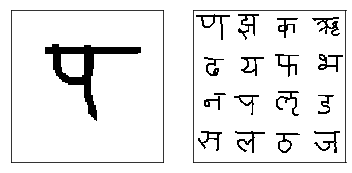

In [79]:
pairs, targets = make_one_shot(16,"train","Sanskrit")
plot_oneshot_task(pairs)

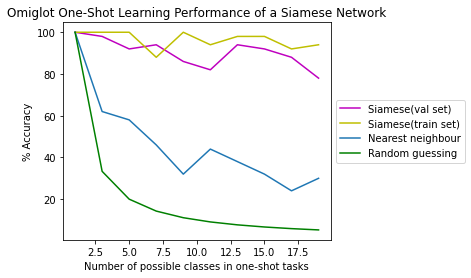

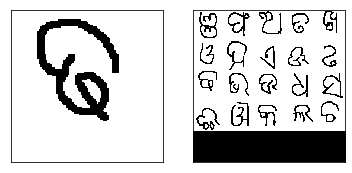

In [81]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_one_shot(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)